<a href="https://colab.research.google.com/github/emirrtpl/adobe-dev-console/blob/main/Eye_Disease_Classification%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T192652Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1222847355da42b43ea86647bdc40a1b92bb2344e52d33a75d261a43bd0c1b3cda97c33525a0248b21b3a0b96a63ebf7db5085b618b33b82f2eb1831518675869bf10e9f111dccced38cb7aadc714289b454ca3b6c3644cc89e68a1353b16f641919f8cab903de8e829724f4d2b1e25cd652b986c88f596675ab331192f1c1374ea7f0c6c7615f97c175bc5b022d7a233b840e2616fe943fc01e4c4067bf6bbfa9be58aa4debc547813f2ca6db85a022b3aebb71408872f766394963ff986dabbbefe2e9437b3f126070c1ccb4bb0d11441de2793db112ce7c17ea03238e0624a382a61f813137ee6920782e5dadc2a8dfd2654b231e9d14d396a3a72131d827'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 771355331 bytes downloaded
Downloaded and uncompressed: eye-diseases-classification
Data source import complete.


#### INTRODUCTION

Eye diseases encompass a wide range of conditions and disorders that can cause visual impairment or vision loss. These conditions can result from genetics, age, environmental factors, or underlying medical conditions. Common eye diseases include glaucoma, characterized by increased intraocular pressure and potential optic nerve damage, cataracts, which cloud the eye's natural lens and lead to blurred vision, and diabetic retinopathy, a condition in individuals with diabetes where high blood sugar damages retinal blood vessels, potentially causing vision loss if not treated.

#### AIM AND OBJECTIVE

The goal of this project is to create a model that accurately identifies and categorizes eye diseases from medical images. This project aims to achieve objectives such as disease identification, accuracy, early detection, efficiency, real-world applicability, generalization, ethical compliance, interpretability, continual learning, and validation. In essence, it strives to develop a reliable and adaptable system for healthcare professionals to diagnose and manage eye diseases, emphasizing accuracy, efficiency, early detection, ethical considerations, and practical use in clinical settings.

#### ABOUT THE DATASET

The dataset consists of retinal images of different classes. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc. The number of images for each class is as follows:

- Cataract = 1038 images
- Glaucoma = 1007 images
- Normal = 1074 images
- Diabetic retinopathy = 1098 images

### 1. Import Necessary liibraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

## 2. Load the dataset

In [ ]:
# import each path of the image classes
glaucoma = Path('/kaggle/input/eye-diseases-classification/dataset/glaucoma')
cataract = Path('/kaggle/input/eye-diseases-classification/dataset/cataract')
normal = Path('/kaggle/input/eye-diseases-classification/dataset/normal')
diabetic_retinopathy = Path('/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy')

In [ ]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/kaggle/input/eye-diseases-classification/dataset/glaucoma: 100%|██████████| 1007/1007 [00:00<00:00, 1029.23it/s]
/kaggle/input/eye-diseases-classification/dataset/cataract: 100%|██████████| 1038/1038 [00:00<00:00, 1754.68it/s]
/kaggle/input/eye-diseases-classification/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1637.97it/s]
/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 1606.12it/s]


In [ ]:
# display the dataframe
df

,image,disease_type
0,/kaggle/input/eye-diseases-classification/data...,0
1,/kaggle/input/eye-diseases-classification/data...,0
2,/kaggle/input/eye-diseases-classification/data...,0
3,/kaggle/input/eye-diseases-classification/data...,0
4,/kaggle/input/eye-diseases-classification/data...,0
...,...,...
4212,/kaggle/input/eye-diseases-classification/data...,3
4213,/kaggle/input/eye-diseases-classification/data...,3
4214,/kaggle/input/eye-diseases-classification/data...,3
4215,/kaggle/input/eye-diseases-classification/data...,3


from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('disease_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# check the count of the target label
df.disease_type.value_counts()

disease_type
3    1098
2    1074
1    1038
0    1007
Name: count, dtype: int64

### Visualizing Images in the dataset

In [ ]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

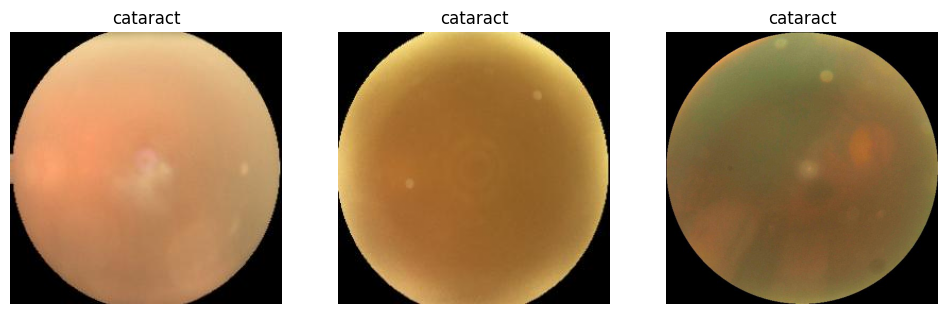

In [ ]:
plot_image(1)

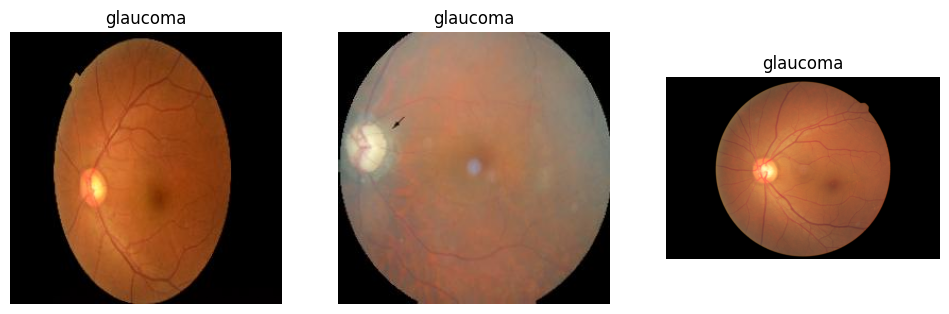

In [ ]:
plot_image(0)

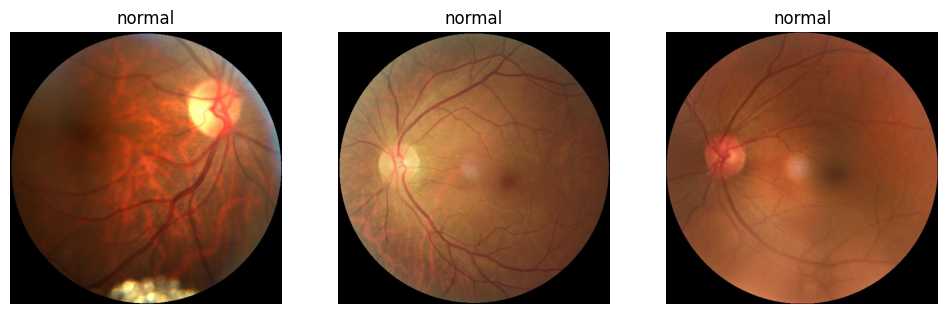

In [ ]:
plot_image(2)

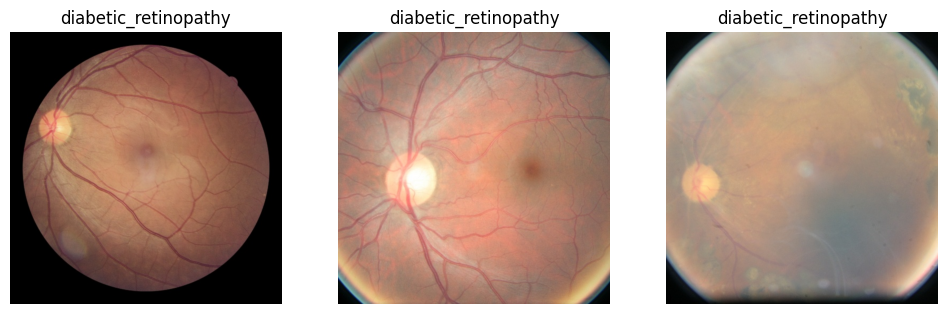

In [ ]:
plot_image(3)

In [ ]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [ ]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

disease_type
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [ ]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

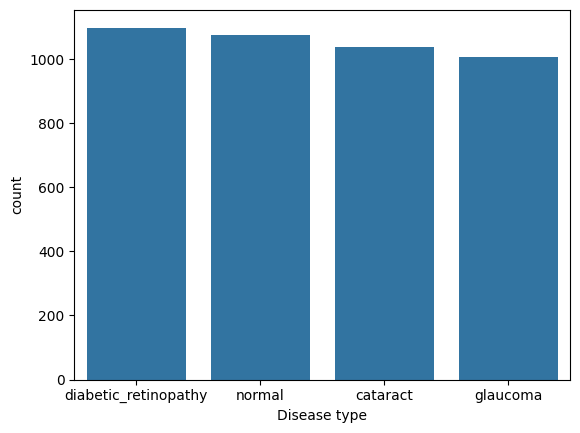

In [ ]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [ ]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

### Model Training

In [ ]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


In [ ]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [ ]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [ ]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
# fitting the model
his = model.fit(
  train_data,
    validation_data=valid_data,
  epochs=15
)

Epoch 1/15
106/106 [==============================] - 191s 2s/step - loss: 0.9036 - accuracy: 0.6037 - val_loss: 0.7038 - val_accuracy: 0.7367
Epoch 2/15
106/106 [==============================] - 195s 2s/step - loss: 0.5921 - accuracy: 0.7582 - val_loss: 0.5520 - val_accuracy: 0.7924
Epoch 3/15
106/106 [==============================] - 190s 2s/step - loss: 0.5288 - accuracy: 0.7807 - val_loss: 0.5403 - val_accuracy: 0.7960
Epoch 4/15
106/106 [==============================] - 185s 2s/step - loss: 0.4486 - accuracy: 0.8192 - val_loss: 0.5113 - val_accuracy: 0.7936
Epoch 5/15
106/106 [==============================] - 194s 2s/step - loss: 0.4088 - accuracy: 0.8331 - val_loss: 0.4990 - val_accuracy: 0.8161
Epoch 6/15
106/106 [==============================] - 207s 2s/step - loss: 0.3842 - accuracy: 0.8521 - val_loss: 0.5762 - val_accuracy: 0.7782
Epoch 7/15
106/106 [==============================] - 202s 2s/step - loss: 0.3466 - accuracy: 0.8580 - val_loss: 0.6363 - val_accuracy: 0.7770

### Visualizing Model Performance

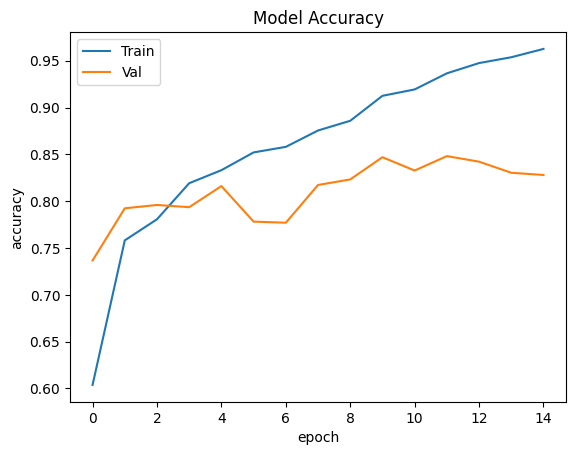

In [ ]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

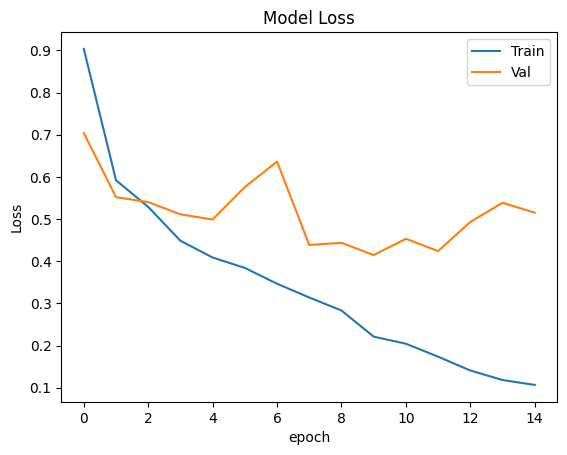

In [ ]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

### Model Evaluation

In [ ]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 16s 585ms/step


In [ ]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.84      0.80      0.82       221
diabetic_retinopathy       0.99      0.98      0.98       217
            glaucoma       0.72      0.72      0.72       205
              normal       0.76      0.81      0.78       200

            accuracy                           0.83       843
           macro avg       0.83      0.83      0.83       843
        weighted avg       0.83      0.83      0.83       843



In [ ]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Select an image')

1/1 [==============================] - 0s 99ms/step


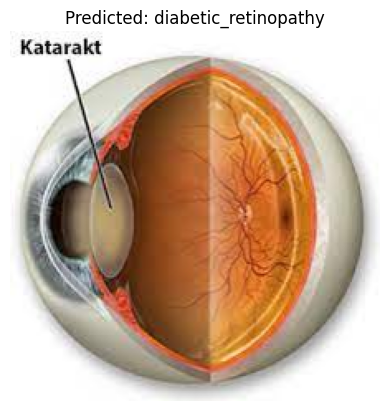

In [ ]:
from ipywidgets import FileUpload, Image
import numpy as np
import io
from PIL import Image as PIL_Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Eğitilmiş modeli yükle
model = load_model('my_model.h5')

def predict_eye_disease(image_data):
    try:
        img = PIL_Image.open(io.BytesIO(image_data))
        img = img.resize((224, 224))  # Görüntüyü 224x224 boyutuna yeniden boyutlandırır
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Tek örneklik veri için boyut ekler
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = labels[predicted_class_index]

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicted: {predicted_class}')
        plt.show()

    except Exception as e:
        print("Bir hata oluştu:", str(e))

# Dosya yükleme işlevi
def on_upload(change):
    for name, file_info in upload_widget.value.items():
        img = file_info['content']
        predict_eye_disease(img)

# Dosya yükleme arayüzü oluşturma
upload_widget = FileUpload(description='Select an image', accept='.jpg,.jpeg,.png', multiple=False)
upload_widget.observe(on_upload, names='value')
display(upload_widget)
